In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('src/')

import csv
from utils import DEFAULT_PALETTE
from WADParser import open_wad_file
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import struct
import re
from copy import deepcopy

In [3]:
w = open_wad_file('WADs/DOOM.WAD')

2025-03-04 21:36:14.791 | INFO     | WADParser:__init__:40 - Found a DOOM IWAD.
2025-03-04 21:36:14.791 | INFO     | WADParser:_get_palette:125 - Palette extracted.
2025-03-04 21:36:14.791 | INFO     | WADParser:_parse_levels:165 - 36 levels found in this WAD.
2025-03-04 21:36:14.801 | INFO     | WADParser:_parse_by_markers:195 - 107 FLATS found in this WAD.
2025-03-04 21:36:14.801 | INFO     | WADParser:_parse_by_markers:195 - 764 SPRITES found in this WAD.
2025-03-04 21:36:14.838 | INFO     | WADParser:_parse_things:137 - DOOM THINGS loaded.


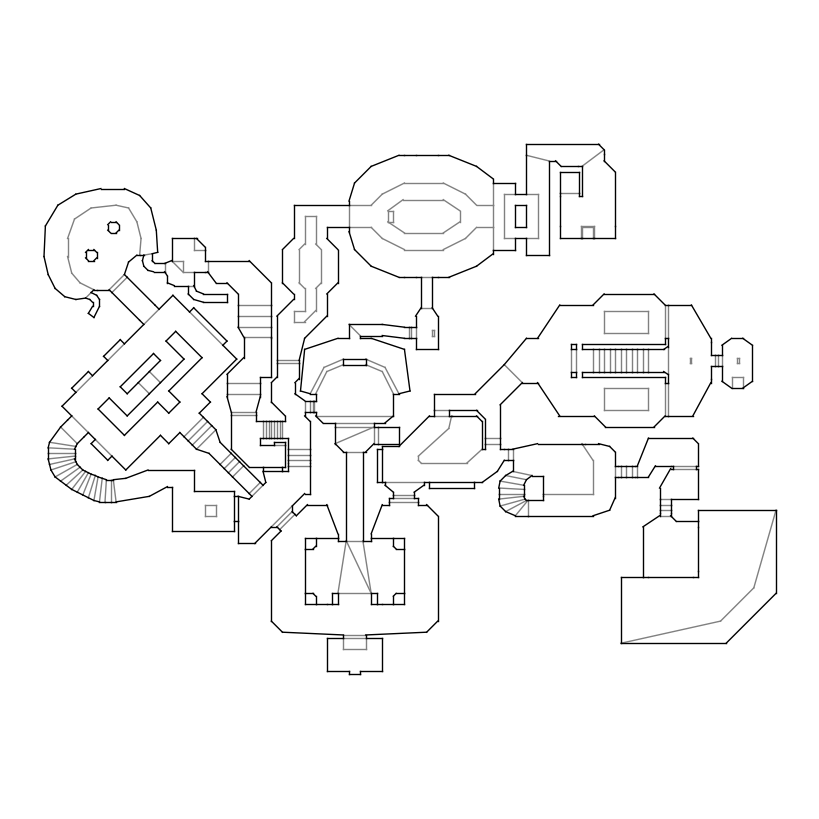

In [8]:
map_infos = w.map('E1M3')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for line in map_infos['steps']:
        ax.plot(line[:, 0], line[:, 1], color='grey', linewidth=1)

for line in map_infos['walls']:
        ax.plot(line[:, 0], line[:, 1], color='black', linewidth=1)

ax.axis('off')
ax.axis('equal')
fig.tight_layout(pad=0)     

In [7]:
d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
lines = []
idx = 0

while True:
    if len(d) == 0: break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        if next_vertex is None:
            break
        line.append(next_vertex)
        start = next_vertex
    lines.append(line)

In [132]:
d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
d2 = d.copy()
lines = []
idx = 0

while True:
    if len(d) == 0: break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        save_vertex = d2.get(start, None)

        if (next_vertex is None) & (save_vertex is None):
            break
        elif (next_vertex is None) & (save_vertex is not None):
            line.append(save_vertex)
            break

        line.append(next_vertex)
        start = next_vertex
    lines.append(line)


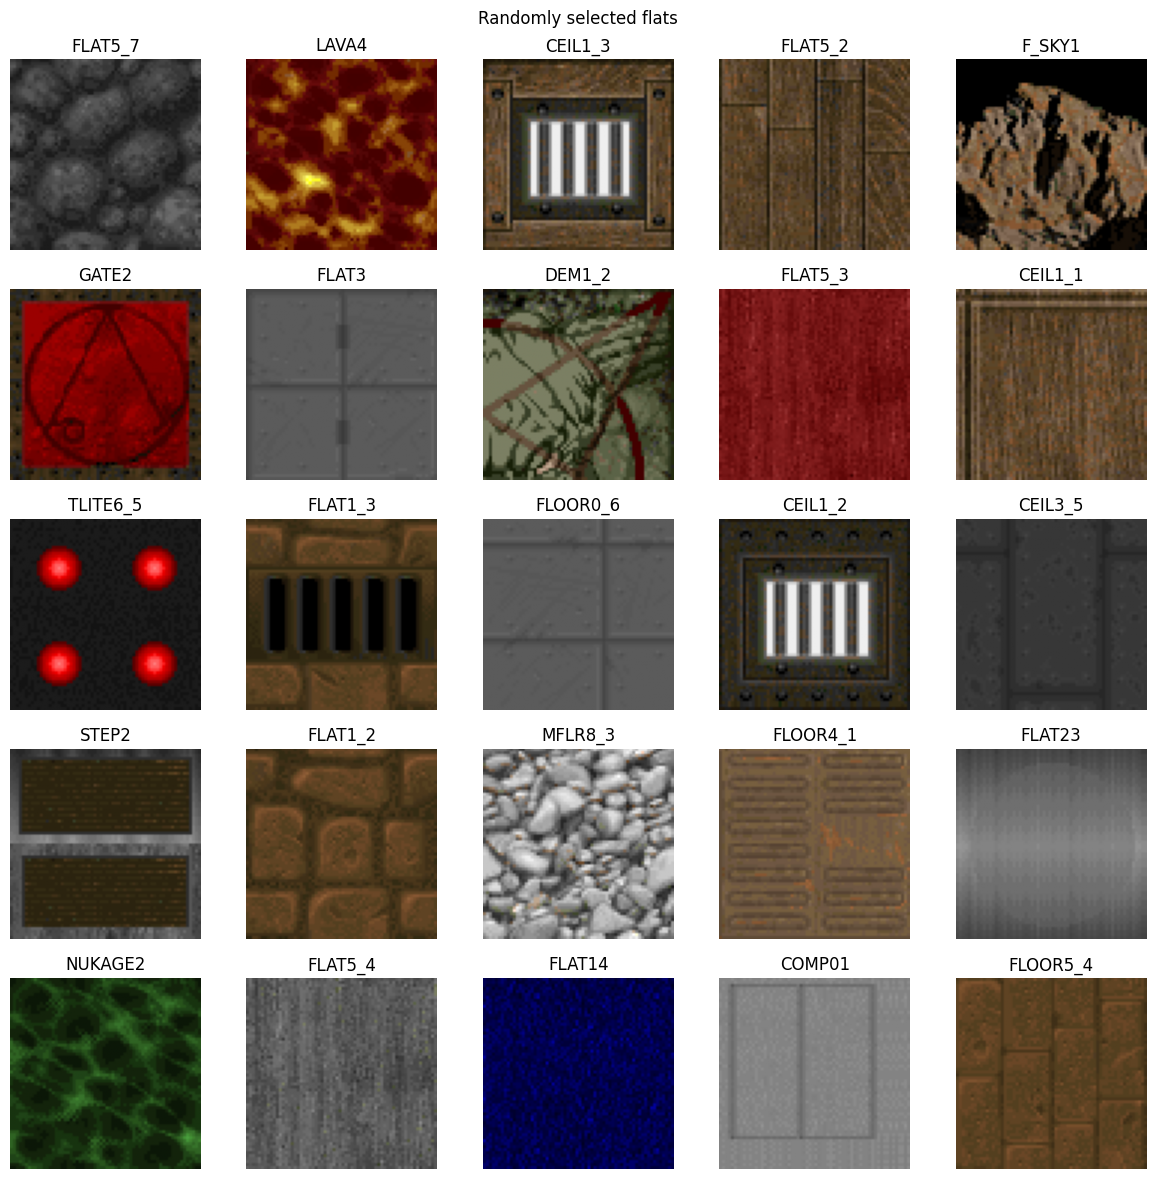

In [9]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_flat_names = list(w.flats.keys())
selected_flats = np.random.choice(all_flat_names, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    rgb_image = w.draw_flat(*w.flats[flat_name])

    ax[i].imshow(rgb_image / 255, aspect='equal')
    ax[i].set_title(flat_name)
    ax[i].axis('off')

fig.suptitle('Randomly selected flats')
fig.tight_layout(pad=1.2)

In [56]:
lump = w._lump_data_by_name('PNAMES')


n_patches = int.from_bytes(lump[0:4], byteorder='little')
patches = []
for i in range(n_patches):
    patch_name = lump[4 + i * 8: 4 + (i + 1) * 8].decode('ascii').rstrip('\0')
    patches.append(patch_name)

lump_id = w.lump_names.index('TEXTURE1')
name, lump_offset, size = w.lumps[lump_id]

w.wad.seek(lump_offset)
texture1_data = w.wad.read(size)

n_textures = int.from_bytes(texture1_data[0:4], byteorder='little')
w.wad.seek(lump_offset + 4)
textures_offsets = []

for i in range(n_textures):
    offset = int.from_bytes(w.wad.read(4), byteorder='little')
    textures_offsets.append(offset)

textures = {}

for tx_offset in textures_offsets:
    w.wad.seek(lump_offset + tx_offset)
    texture_name = w.wad.read(8).decode('ascii').rstrip('\0')
    w.wad.seek(4, 1)  # skip mask offset
    width, height = struct.unpack('<HH', w.wad.read(4))
    w.wad.seek(4, 1)  # skip columndirectory offset
    patch_count = int.from_bytes(w.wad.read(2), byteorder='little')

    map_patches = np.array([struct.unpack("<hhH", w.wad.read(6)) for i in range(patch_count)])
    orig_x = map_patches[:, 0]
    orig_y = map_patches[:, 1]
    patch_idxs = map_patches[:, 2]

    textures[texture_name] = {'width': width, 'height': height, 'patch_count': patch_count, 
                              'orig_x': orig_x, 'orig_y': orig_y, 'patch_idxs': patch_idxs}

textures

{'AASTINKY': {'width': 24,
  'height': 72,
  'patch_count': 2,
  'orig_x': array([0, 1]),
  'orig_y': array([0, 0]),
  'patch_idxs': array([ 0, 12])},
 'BIGDOOR1': {'width': 128,
  'height': 96,
  'patch_count': 5,
  'orig_x': array([ 0,  1, 24,  0,  2]),
  'orig_y': array([ 0,  0,  1, 17,  1]),
  'patch_idxs': array([1, 0, 1, 0, 0])},
 'BIGDOOR2': {'width': 128,
  'height': 128,
  'patch_count': 1,
  'orig_x': array([0]),
  'orig_y': array([0]),
  'patch_idxs': array([3])},
 'BIGDOOR4': {'width': 128,
  'height': 128,
  'patch_count': 1,
  'orig_x': array([0]),
  'orig_y': array([0]),
  'patch_idxs': array([4])},
 'BRNBIGC': {'width': 128,
  'height': 128,
  'patch_count': 1,
  'orig_x': array([0]),
  'orig_y': array([0]),
  'patch_idxs': array([5])},
 'BRNBIGL': {'width': 32,
  'height': 128,
  'patch_count': 1,
  'orig_x': array([0]),
  'orig_y': array([0]),
  'patch_idxs': array([6])},
 'BRNBIGR': {'width': 32,
  'height': 128,
  'patch_count': 1,
  'orig_x': array([0]),
  'orig_y'

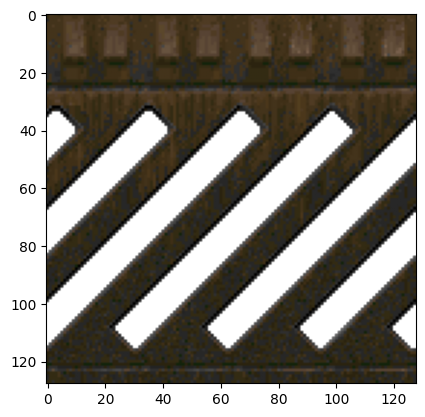

In [ ]:
texture = 'BRNBIGC'

texture_data = textures[texture]
pixmap = np.zeros((texture_data['height'], texture_data['width']), dtype=np.uint8)
alphamap = np.zeros((texture_data['height'], texture_data['width']), dtype=np.uint8)
for x, y, patch in zip(texture_data['orig_x'], texture_data['orig_y'], texture_data['patch_idxs']):
    patch_name = patches[patch]
    
    idx = w.lump_names.index(patch_name)

    _, offset, size = w.lumps[idx]
    img, alpha, _, _ = w._read_patch_data(offset, size)

    pixmap[y:y+img.shape[0], x:x+img.shape[1]] = img
    alphamap[y:y+img.shape[0], x:x+img.shape[1]] = alpha

    alpha = alpha.T[:, :, np.newaxis] * np.ones((1, 1, 4))


rgb_img = w.palette[img.T]

rgba_img = rgb_img * alpha
plt.imshow(rgba_img / 255)  


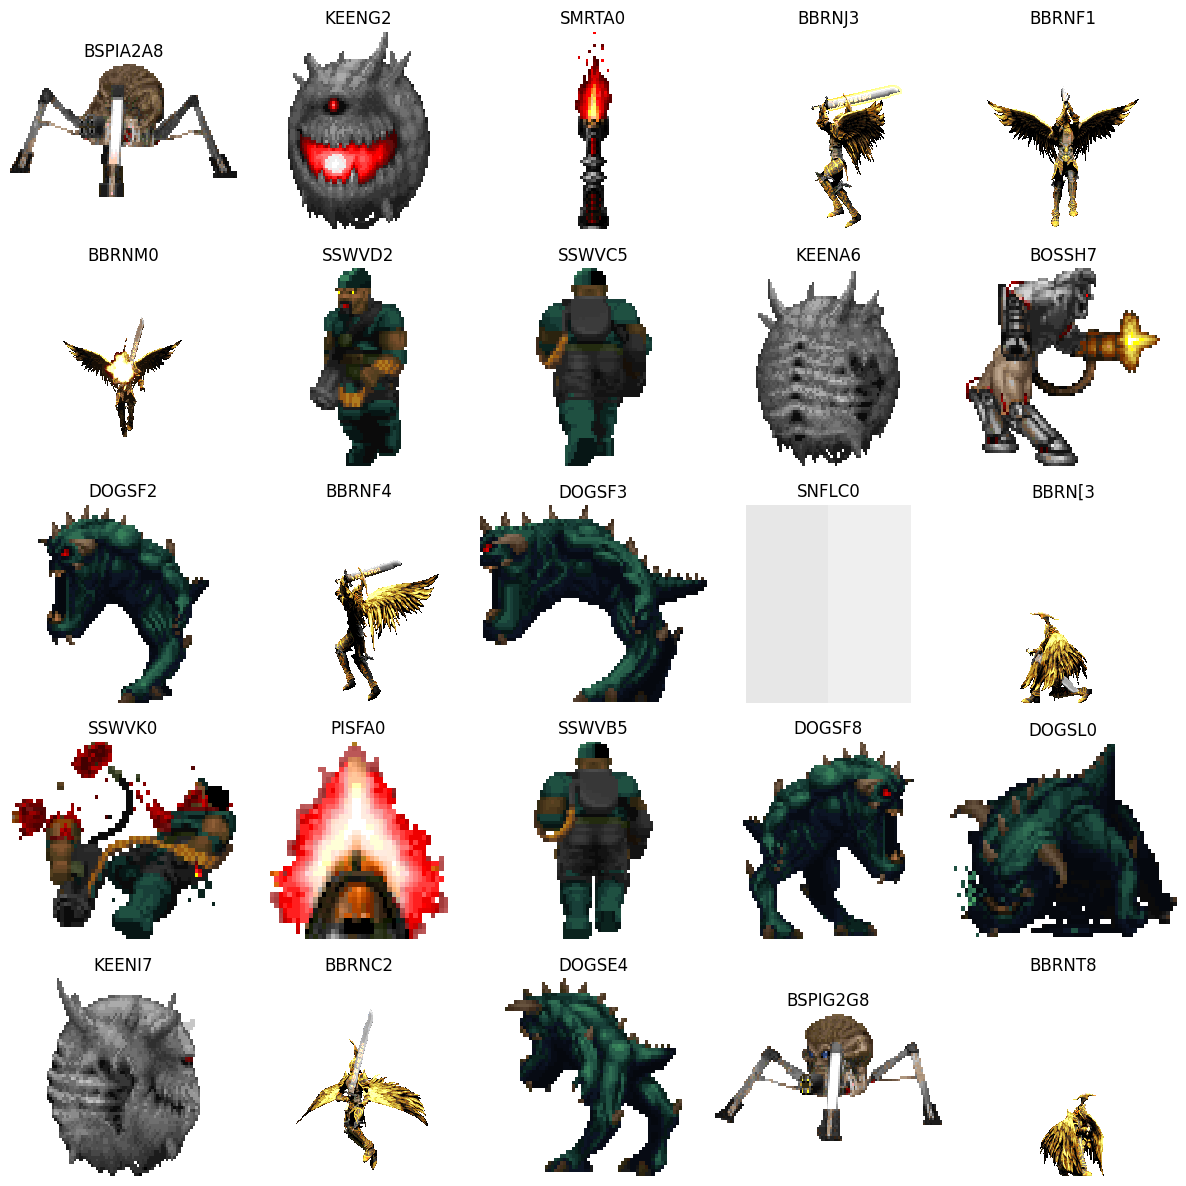

In [83]:
n_sprites = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_sprite_names = list(w.sprites.keys())
selected_sprites = np.random.choice(all_sprite_names, size=n_sprites, replace=False)

for i, sprite_name in enumerate(selected_sprites):

    rgb_image = w.draw_patch(*w.sprites[sprite_name])

    # Original DOOM had non-square pixels!
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest') 
    ax[i].set_title(sprite_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)

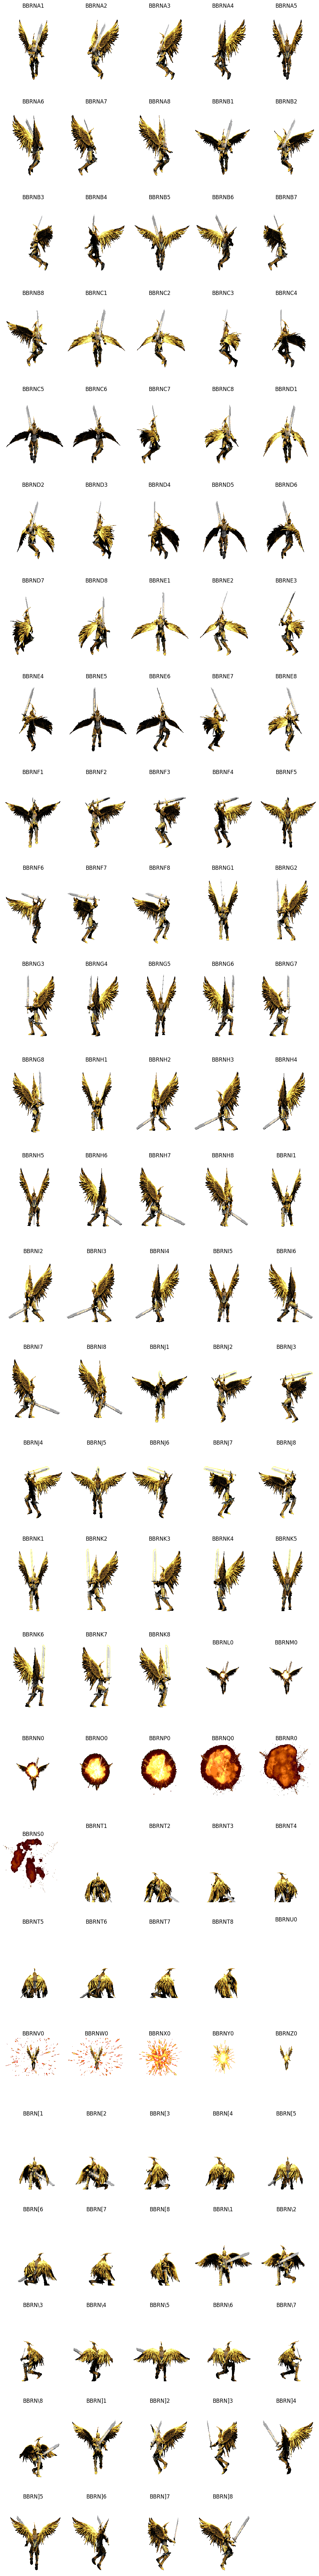

In [85]:
sprite_name = 'BBRN'

sprite_list = w.spritesheets[sprite_name]
ncols=5
nrows = int(np.ceil(len(sprite_list) / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*nrows))
ax = ax.ravel()

for i, (name, offset, size) in enumerate(sprite_list):
    
    rgb_image = w.draw_patch(offset, size)
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest')
    ax[i].set_title(name)
    ax[i].axis('off')

[ax[i].set_visible(False) for i in range(len(sprite_list), len(ax))]
fig.tight_layout(pad=0.8)

In [10]:
# Example linedefs array (replace this with your actual data)
linedefs = np.array([[1, 2], [2, 3], [3, 4], [4, 1]])

d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
lines = []
idx = 0

while True:
    if len(d) == 0:
        break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        if next_vertex is None:
            break
        line.append(next_vertex)
        start = next_vertex
    lines.append(line)

print(lines)

[[1, 2, 3, 4, 1]]
